### Assessment 4
***GitHub Link:*** https://github.com/manansuthar55/CSE6037_20MAI0016/tree/main/Assessment_4
#### Problem 1: Transfer Learning using AlexNet for feature extraction.

In [2]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
from torchvision import models
from torchvision import transforms
from PIL import Image
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [4]:
os.listdir('../input/leapgestrecog/leapGestRecog')

['07', '05', '06', '02', '04', '00', '08', '09', '03', '01']

In [9]:
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 1.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

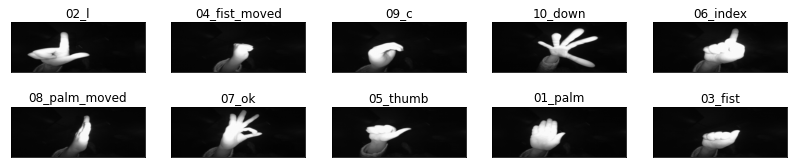

In [10]:
dir = '../input/leapgestrecog/leapGestRecog'
folders = os.listdir(dir)
folder_person = [dir + '/' + folder for folder in folders][0]
folder_gesture = [folder_person + "/" + gesture for gesture in os.listdir(folder_person)]
gestures = [gesture for gesture in os.listdir(folder_person)]
all_images = []
for i in range(len(folder_gesture)):
    all_images.append(os.listdir(folder_gesture[i])[0])
images = []
for i in range(len(folder_gesture)):
    images.append(folder_gesture[i] + "/" + all_images[i])
images = np.array([cv2.imread(image, cv2.IMREAD_GRAYSCALE) for image in images])
names = [name for name in gestures]
plot_portraits(images, names, 256, 256, n_row=2, n_col=5)

## Feature Extraction

In [11]:
def extractFeatures(img):
    transform = transforms.Compose([            
      transforms.Resize(256),                   
      transforms.CenterCrop(224),               
      transforms.ToTensor(),                    
      transforms.Normalize(                     
      mean=[0.485, 0.456, 0.406],               
      std=[0.229, 0.224, 0.225]                 
    )])
    img = img.convert('RGB')
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    out = alexnet(batch_t)
    assert out.shape == torch.Size([1, 4096])
    output = out.detach().numpy()
    output = np.reshape(output, 4096)
    return output

In [12]:
def prepare_data(path):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    i=1
    for folder_person in os.listdir(path):
        for folder_gesture in os.listdir(path + folder_person):
            for file in os.listdir(path + folder_person + "/" + folder_gesture)[0:30]:
                image = Image.open(os.path.join(path + folder_person + "/" + folder_gesture, file))
                if(i<5):
                    image_with_features = extractFeatures(image)
                    X_train.append(image_with_features)
                    y_train.append(int(folder_gesture[0:2]))
                    i+=1
                else:  
                    image_with_features = extractFeatures(image)
                    X_test.append(image_with_features)
                    y_test.append(int(folder_gesture[0:2]))
                    i=1
    return X_train, y_train, X_test, y_test

## Importing pre-trained AlexNet

In [14]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier = nn.Sequential(*[alexnet.classifier[i] for i in range(5)])

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [15]:
def model_building(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    return score

In [17]:
DATASET_PATH = "../input/leapgestrecog/leapGestRecog/"
X_train, y_train, X_test, y_test = prepare_data(DATASET_PATH)

In [18]:
models = [(KNeighborsClassifier(n_neighbors=9), "KNN Classifier with 9 neighbors"),
          (GaussianNB(), "Naive Bayes Classifier")]

for model in models:    
    score = model_building(model[0], X_train, X_test, y_train, y_test)
    print("{} score: {}".format(model[1],score))

KNN Classifier with 9 neighbors score: 0.9733333333333334
Naive Bayes Classifier score: 0.7933333333333333
